<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/nearest_neighbour_analysis_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.special import erf
from sklearn.cluster import DBSCAN
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import cm

import glob
import os
import gc

In [ ]:
def grf_2d(mean, std_dev, pixel, amplitude, k_power):
    # Generate white noise in-place
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel))

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fft2(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel) * pixel
    ky = np.fft.fftfreq(pixel) * pixel

    # Generating FFT momentum 2D array
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    del kx, ky
    gc.collect()

    # Norm of k
    k_norm = np.sqrt(kx_grid**2 + ky_grid**2)
    k_norm[0, 0] = np.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid
    gc.collect()

    # Power Spectrum P_k
    power_spectrum = amplitude * (((2 * np.pi / pixel) * k_norm) ** (-k_power))
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum, out=power_spectrum) * fft_white_noise
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifft2(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field


def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)



def M(c2, c1, threshold):

    """
    First input : above-threshold overdensity
    Second input : above-threshold overdensity



    Define
    M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
    If[delta1 <= 0.599,
    HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

    delta2 (c2) is the amplitude of the above-threshold overdensity,
    delta1 (c1) is the amplitude of an overdensity in one of the
    nearest-neighbouring patches.

    For each nearest-neighbouring patch add deltaM to the mass
    of the "bare" above-threshold patch, M[0,delta2],
    to get the total mass in units of the horizon mass.

    """


    """
    linearly re-scale the amplitudes delta1 and delta2 such that
    0.6 corresponds to the utilised threshold value (at a given rareness).
    """

    c1 = 0.6 * c1 / threshold
    c2 = 0.6 * c2 / threshold


    if c1 <= 0.599:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181 * np.heaviside(c2 - 0.002/(c1-0.6) - 0.6, 0)

    else:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181


def dM(c2, c1, threshold):

    """
    Approximate mass increase for each nearest-neighbouring overdensity.
    (Through the "If" command, I have set it equal to zero whenever the
    threshold is not met.)

    deltaM[delta1,delta2]:=If[M[0, delta2] == 0, 0, M[delta1, delta2]-M[0, delta2]]
    """

    mass = M(c2,c1,threshold)

    if mass == 0:
        return 0
    else:
        return mass - M(c2,0,threshold)


def total_M(M_list):
    return np.sum(M_list)
    """
    M_total = Sum_{j in cluster} M[0, delta2_j]
    + Sum_{i=1}^{8} deltaM[delta1_i,delta2_j],
    wherein the second sum runs over all eight nearest neighbours.
    The indices j represents here the threshold exceeding events.
    """

## Please then make a series of plots for each case (exponential and
## Gaußian random fields with n = 0, 1, 2, 3 each), wherein you
## compare the initial mass sepctrum (M0) with M_total

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

folder_path = '/content/gdrive/My Drive/0 Article/PBH/Proof_of_concepts/data/'
main_path = folder_path + f'k_{k_power}'
os.chdir(main_path)

MessageError: Error: credential propagation was unsuccessful

In [ ]:
k_power = 2

exprf = gaussian_to_exp( grf_2d(mean= 0, std_dev = 1, pixel= 2**11, amplitude = 1, k_power=k_power), 1)

In [ ]:
# os.chdir(main_path)

# exprf_list = glob.glob('exprf*.npy')
# print(exprf_list)
# exprf = np.load(exprf_list[0])
print(exprf.shape)

(2048, 2048)


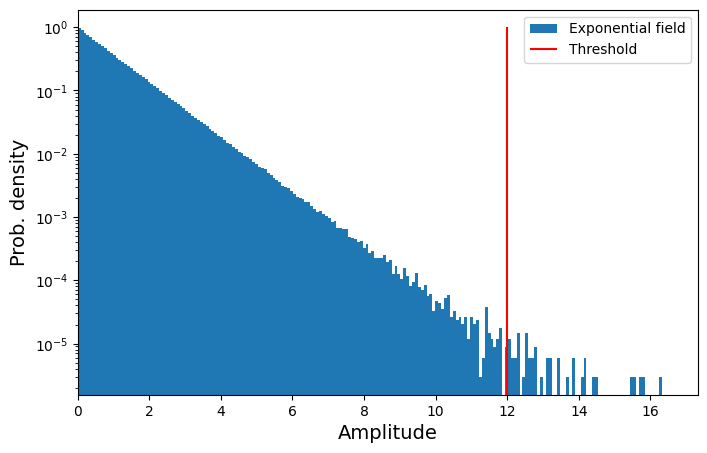

In [ ]:
threshold = 12
#threshold = 11

plt.figure( figsize = (8,5))
plt.hist(exprf.flatten(), bins=201, density=True, label='Exponential field');
plt.yscale('log')
plt.xlim(0,exprf.max()+1)
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Prob. density', fontsize=14)
plt.vlines(threshold,0,1, color='r', label='Threshold')
plt.legend()
plt.savefig('Prob_dens.pdf', bbox_inches='tight', dpi=300)
plt.show()

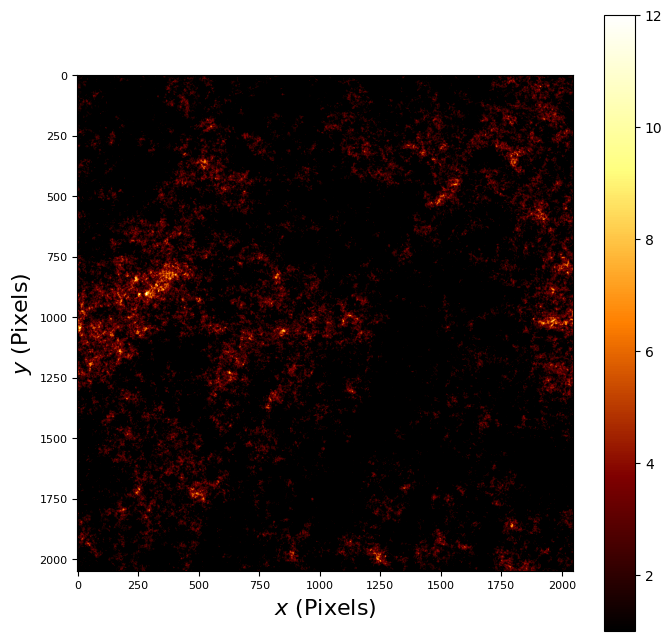

In [ ]:
psize = 8

plt.figure( figsize = (psize,psize))
plt.imshow(exprf, cmap='afmhot')
plt.xlabel(f'$x$ (Pixels)',fontsize=psize*2)
plt.ylabel(f'$y$ (Pixels)',fontsize=psize*2)
plt.xticks(fontsize=psize)
plt.yticks(fontsize=psize)
plt.colorbar()
plt.clim(1,threshold)
plt.savefig('Field.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# threshold = 11
# 2048
threshold = threshold
# 8192
mask = exprf > threshold

In [ ]:
pos = np.argwhere(mask)
print(pos.shape)

(46, 2)


In [ ]:
eps = 100
min_samples = 2

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(pos)

In [ ]:
labels = clustering.labels_
print(labels)

[ 0  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  2  2  2  2  2  3  3  3  3 -1 -1 -1 -1]


In [ ]:
num_clt = len(set(labels))
cmap = cm.get_cmap('rainbow', num_clt)

print(num_clt)

5


<ipython-input-12-33e86091dd2b>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', num_clt)


In [ ]:
# plt.figure( figsize = (8,8))

# for ii in set(labels):
#     clt_idx = np.where(labels == ii)
#     clt_pos = pos[clt_idx]
#     color = cmap(ii % num_clt)

#     if ii == -1:
#         plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
#     else:
#         plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}')

#     for p in clt_pos:
#         circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
#         plt.gca().add_artist(circle)


# plt.xlabel(f'$x$ (Pixels)', fontsize=14)
# plt.ylabel(f'$y$ (Pixels) ', fontsize=14)
# plt.xlim(0,exprf.shape[0])
# plt.ylim(-exprf.shape[1],0)
# plt.legend()
# plt.savefig('Cluster.pdf', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# Initialize empty dictionary
clt_pos_dict = {}

# Iterate over all clustes
for ii in set(labels):

    # Find the index of the cluster
    clt_idx = np.where(labels == ii)
    # Find the coordinates of the cluster using the index
    clt_pos = pos[clt_idx]
    # Append the coordinates into the dictionary
    clt_pos_dict[ii] = clt_pos


In [ ]:
l = 1 ## box size = 2L+1


"""
Structure of the dictoinary:
coordinates[i][j] referes to the coordinate of the i-th cluster
and the j-th threshold exceeding events.
"""

# Generate offsets for the 3x3 box
offsets = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1)])
# Generate offsets for the 3x3 box exlcuding center
offsets_no_center = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1) if not (i==0 and j==0)] )

# Initialize empty dictionary to store the all coordinates of the box
coordinates = {}
uni_coordinates = {}
# Initialize empty dictionary to store only the nearest neighbour
coordinates_nn = {}
# Initialize empty dictionary to store o

# Iterate over each cluster in labels, exlcuding `-1`
for ii in set(labels) - {-1}:

    # Initialize empty list for collecting coordinates in cluster `ii`
    coordinates[ii] = []
    coordinates_nn[ii] = []
    uni_coordinates[ii] = []

    # Iterate over the coordinates of each box center
    for coor_center in clt_pos_dict[ii]:

        # Append the coordinates for the entire box (arrays)
        coordinates[ii].append(coor_center + offsets)
        # Append the coordinates only for the nearest neighbours
        coordinates_nn[ii].append(coor_center + offsets_no_center)

    # Concatenate lists of arrays into a single array
    coordinates[ii] = np.concatenate(coordinates[ii])

    # Remove duplications
    uni_coordinates[ii] = np.unique(coordinates[ii], axis=0)

Cluster0: total mass list [7.249652613067902, 13.874412585052735]
Cluster0: bare mass list [3.110788763741838, 4.26193989661959]
Cluster0: total mass list 21.124065198120636
Cluster0: bare_mass list 7.372728660361428
Cluster1: total mass list [16.88477212014512, 21.954460308826857, 19.273539673707663, 17.632645725413695, 29.972024261221385, 24.84694209970031, 16.62411920652594, 22.60345642286753, 26.357453102003923, 23.85981854476405, 31.235587138338964, 44.14578740986544, 14.735743931953365, 31.6315198674928, 39.05681312692617, 15.668478697578895, 33.46048271149153, 45.65801164700148, 57.83816459691043, 48.56278338309551, 26.406146327112424, 16.55654917601776, 50.7760832748605, 55.32117446588406, 38.945751097547706, 21.56286111127774, 47.87864255141591, 38.77062636807676, 12.670435610307695, 33.46131086790308]
Cluster1: bare mass list [5.39914294134137, 4.71605673137973, 3.275928797005856, 3.059465901714314, 8.446632621243278, 3.6011070429802023, 3.7042837889054816, 3.5412397019738915

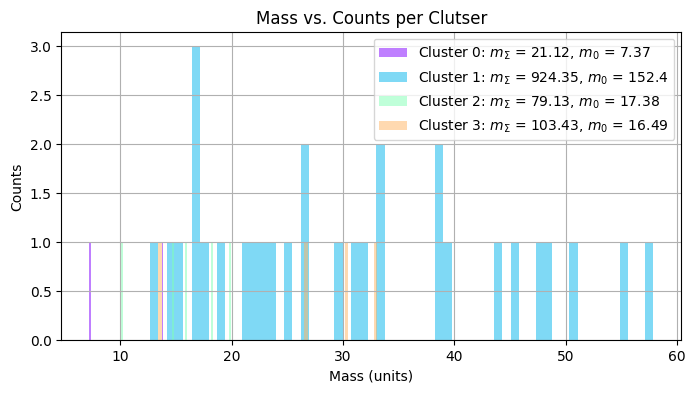

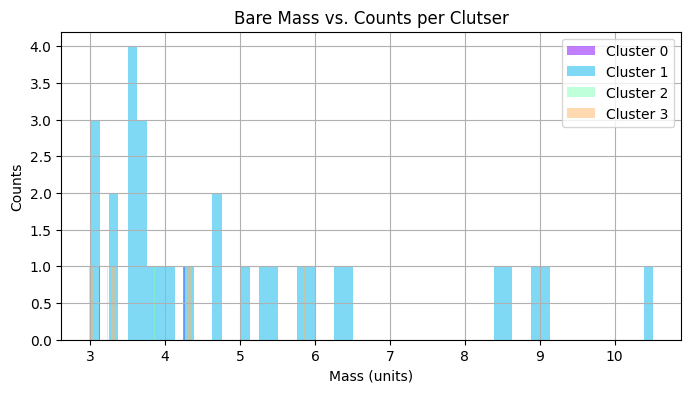

In [ ]:

"""
Define indices and variables:

i = Cluster
j = Threshold Exceedence
k = Nearest Neighbours


d2 = delta2 = Threshold exceedence amplitude
d1 = delta1 = Nearest neighbour amplitude
"""

# Intialize empty list - vector
cluster_mass_i = {}
bare_mass_i = {}

# Initialize empty dictionary - rank 2 tensor
# Total mass for all threshold exceedence [j] in each clsuter [i]
# Total mass for all threshold exceedence [j] in each cluster [i]
cluster_mass_list_ij, bare_mass_list_ij = {} , {}

# for ii in set(labels) -{-1, 1, 2,3,4}:
for ii in set(labels) -{-1}:
    #Intiialize empty list for each cluster for storing m_ijk
    cluster_mass_list_ij[ii], bare_mass_list_ij[ii] = [] , []
    #Intiialize empty list for each cluster M_ij
    cluster_mass_i[ii], bare_mass_i[ii] = [], []

    for jj in range(clt_pos_dict[ii].shape[0]):
        ## amplitude of the j-th threshold exceedence in the i-th cluster - rank 2 tensor
        d2_ij = exprf[ clt_pos_dict[ii][jj,0], clt_pos_dict[ii][jj,1] ]
        ## amplitudes in the nearest neighbourhood for the j-th threshold exceedence - rank 3 tensor
        d1_ijk = exprf[ coordinates_nn[ii][jj][:,0], coordinates_nn[ii][jj][:,1] ]

        # Initialize empty list - rank 3 tensor
        ## delta M, additional mass due to nearest neighbour
        dM_ijk = []

        """
        Define
        M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
        If[delta1 <= 0.599,
        HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

        delta2 (d2) is the amplitude of the above-threshold overdensity,
        delta1 (d1) is the amplitude of an overdensity in one of the
        nearest-neighbouring patches.
        """

        # Calculate additional mass for each nearest neighbour
        for d1 in d1_ijk:
            dM_ijk.append( dM(d1, d2_ij, threshold) )
            # print("Amplitude =", d1, "Neighbor =", dM(d1, d2_ij, threshold) )

        # Total mass for a given threshold exceedence in a given cluster
        # Sum over [k] and the threshold exceedenece
        def nn_sum(dM_list):
            return np.sum(dM_ijk) + M(d2_ij, 0, threshold)
        # print("neighborhood = ", np.sum(dM_ijk) , "bare =",  M(d2_ij, 0, threshold))

        # Total mass for a given threshold exceedence in a given cluster
        cluster_mass_list_ij[ii].append(nn_sum(dM_ijk))
        # Bare mass for a given threshold exceedence in a given cluster
        bare_mass_list_ij[ii].append(M(d2_ij, 0, threshold))

    cluster_mass_i[ii] = np.sum(cluster_mass_list_ij[ii])
    bare_mass_i[ii] = np.sum(bare_mass_list_ij[ii])


    print(f"Cluster{ii}: total mass list", cluster_mass_list_ij[ii])
    print(f"Cluster{ii}: bare mass list", bare_mass_list_ij[ii])

    print(f"Cluster{ii}: total mass list", cluster_mass_i[ii] )
    print(f"Cluster{ii}: bare_mass list", bare_mass_i[ii] )

plt.figure( figsize = (8,4))

for ii in set(labels)-{-1}:
    color = cmap(ii % num_clt)
    plt.hist(cluster_mass_list_ij[ii][:], bins=60, label=f'Cluster {ii}: $m_\Sigma$ = {np.round(cluster_mass_i[ii],2)}, $m_0$ = {np.round(bare_mass_i[ii],2)}' , alpha =0.5, color=color)
plt.legend()
plt.title("Mass vs. Counts per Clutser")
plt.xlabel("Mass (units)")
plt.ylabel("Counts")
plt.grid()
plt.show()

plt.figure( figsize = (8,4))
for ii in set(labels)-{-1}:
    color = cmap(ii % num_clt)
    plt.hist(bare_mass_list_ij[ii][:], bins=60,  label=f'Cluster {ii}', alpha =0.5, color=color)
plt.title("Bare Mass vs. Counts per Clutser")
plt.xlabel("Mass (units)")
plt.ylabel("Counts")
plt.grid()
plt.legend()
plt.show()




In [ ]:
bare_mass_i

{0: 7.372728660361428,
 1: 152.40255079979184,
 2: 17.382496214296165,
 3: 16.486496278536844}

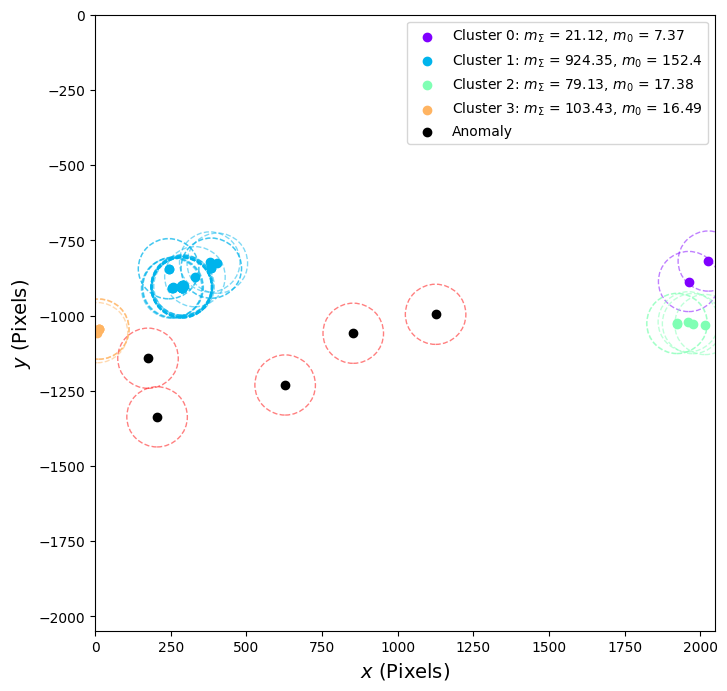

In [ ]:
plt.figure( figsize = (8,8))

for ii in set(labels):
    clt_idx = np.where(labels == ii)
    clt_pos = pos[clt_idx]
    color = cmap(ii % num_clt)

    if ii == -1:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
    else:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}: $m_\Sigma$ = {np.round(cluster_mass_i[ii],2)}, $m_0$ = {np.round(bare_mass_i[ii],2)}' )

    for p in clt_pos:
        circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
        plt.gca().add_artist(circle)


plt.xlabel(f'$x$ (Pixels)', fontsize=14)
plt.ylabel(f'$y$ (Pixels) ', fontsize=14)
plt.xlim(0,exprf.shape[0])
plt.ylim(-exprf.shape[1],0)
plt.legend()
plt.savefig('Cluster.pdf', bbox_inches='tight', dpi=300)
plt.show()

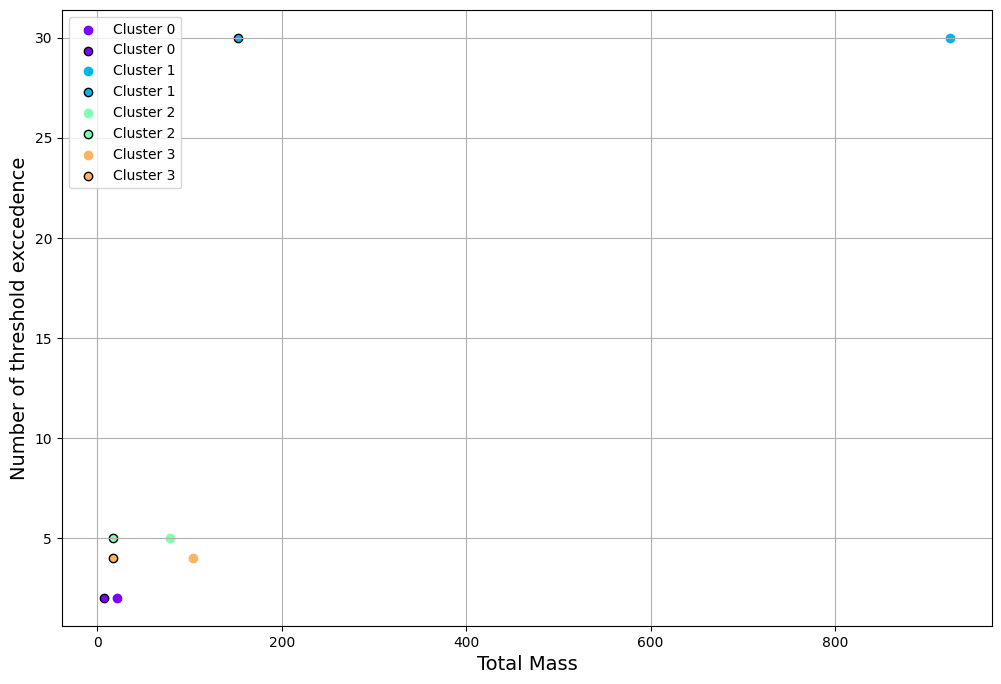

In [ ]:
plt.figure( figsize = (12,8))
for ii in set(labels) - {-1}:
    color = cmap(ii % num_clt)
    plt.scatter( cluster_mass_i[ii], clt_pos_dict[ii].shape[0], label=f'Cluster {ii}',  color = color)
    plt.scatter( bare_mass_i[ii], clt_pos_dict[ii].shape[0], label=f'Cluster {ii}',  color = color, edgecolors='black')
#cluster_mass_list_ij
plt.legend()
plt.xlabel('Total Mass', fontsize=14)
plt.ylabel('Number of threshold exccedence', fontsize=14)
plt.grid()
plt.savefig('Mass_vs_Thres_ex.pdf', bbox_inches='tight', dpi=300)
plt.show()

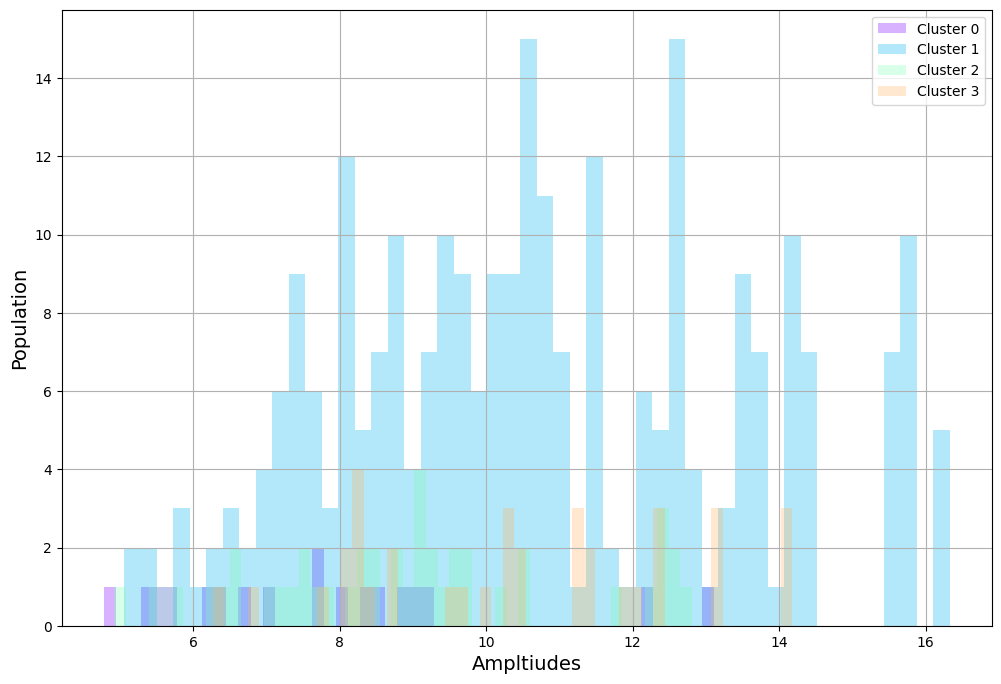

In [ ]:
amplitude_list = {}

for ii in set(labels) - {-1}:
    amplitude_list[ii] = []
    amplitude_list[ii] = exprf[coordinates[ii][:,0], coordinates[ii][:,1]]


plt.figure( figsize = (12,8))
for ii in set(labels) - {-1}:

    color = cmap(ii % num_clt)
    plt.hist(amplitude_list[ii], bins=50, label=f'Cluster {ii}', color = color, alpha=0.3)

plt.legend()
plt.xlabel('Ampltiudes', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.grid()
plt.savefig('Amp_hist.pdf', bbox_inches='tight', dpi=300)
plt.show()

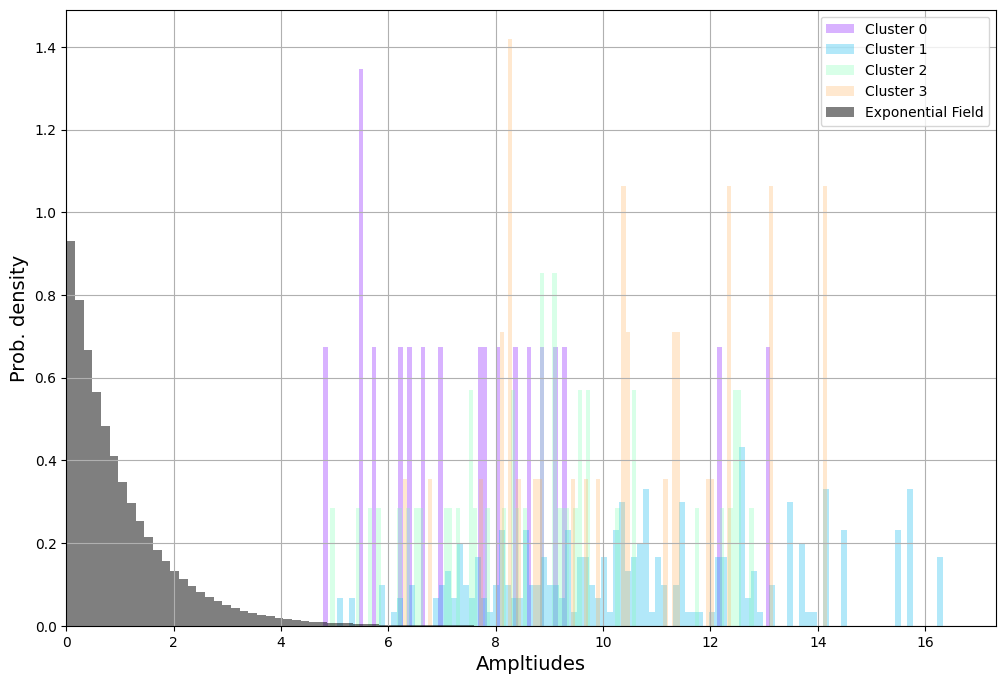

In [ ]:
plt.figure( figsize = (12,8))
for ii in set(labels) - {-1}:
    color = cmap(ii % num_clt)
    plt.hist(amplitude_list[ii], bins=101,  label=f'Cluster {ii}', color = color, density=True,alpha =0.3)

plt.hist(exprf.flatten(), bins=101,  label='Exponential Field', color = 'k', density=True, alpha=0.5)
plt.legend()
plt.xlabel('Ampltiudes', fontsize=14)
plt.ylabel('Prob. density', fontsize=14)
plt.xlim(0,exprf.max()+1)
plt.grid()
plt.savefig('Amp_hist_with_exprf.pdf', bbox_inches='tight', dpi=300)
plt.show()

Cluster 0


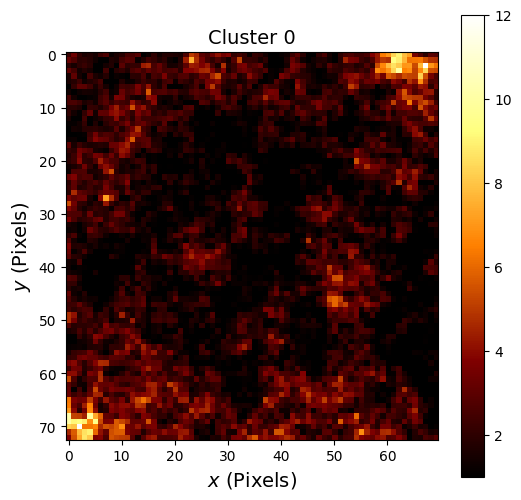

Cluster 1


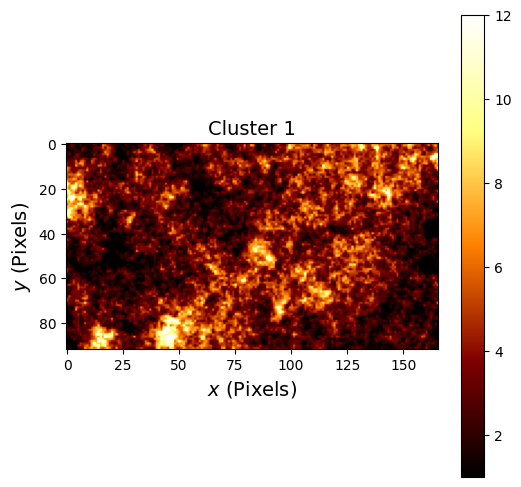

Cluster 2


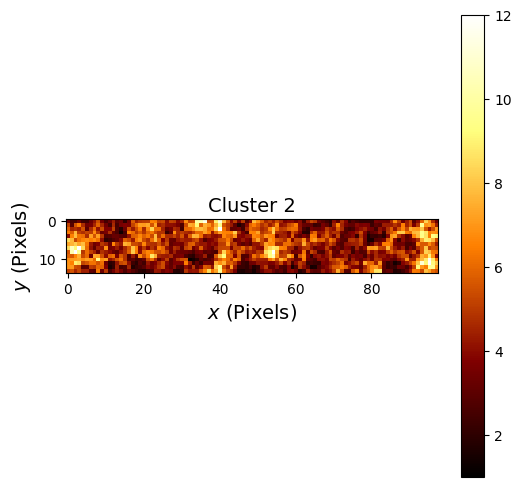

Cluster 3


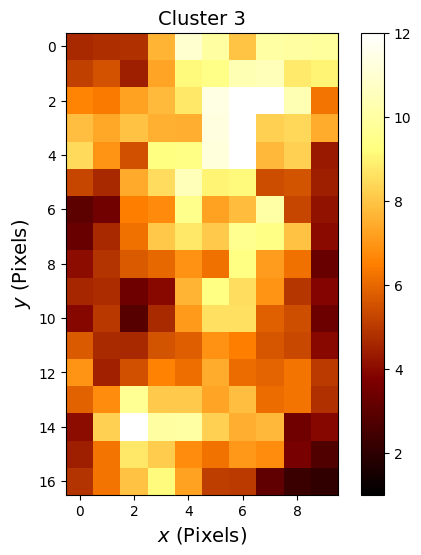

In [ ]:
for ii in set(labels) - {-1}:

    print(f'Cluster {ii}')

    l0 = 1

    xmin = coordinates[ii][:,0].min() - l0
    xmax = coordinates[ii][:,0].max() + l0 +1
    ymin = coordinates[ii][:,1].min() - l0
    ymax = coordinates[ii][:,1].max() + l0 +1

    subexprf = exprf[xmin:xmax , ymin:ymax]

    plt.figure(figsize = (6,6))

    plt.imshow(subexprf, cmap='afmhot')
    plt.title(f'Cluster {ii}', fontsize=14)
    plt.xlabel(f'$x$ (Pixels)',fontsize=14)
    plt.ylabel(f'$y$ (Pixels)',fontsize=14)
    plt.colorbar()
    plt.clim(1,threshold)
    plt.savefig(f'SmallCluster_{ii}.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
import numpy as np

# Example arrays A and B
A = np.array([1, 2, 3, 4, 5])
B = np.array([2, 4, 6, 7, 8, 9, 10])

# Remove elements in A that are present in B
A_filtered = np.setdiff1d(A, B)

print("Original A:", A)
print("Filtered A:", A_filtered)

Original A: [1 2 3 4 5]
Filtered A: [1 3 5]


In [ ]:
pos_amp_list = {}

ii = 1

pos_amp_list[ii] = []

x_coor = clt_pos_dict[ii][:,0]
y_coor = clt_pos_dict[ii][:,1]

pos_amp_list[ii] = np.column_stack( (clt_pos_dict[ii], exprf[x_coor, y_coor]) )


In [ ]:
s_pos_amp_list = {}
s_pos_amp_list[ii] = []
s_pos_amp_list[ii] = sorted(pos_amp_list[ii], key=lambda x: x[2], reverse=True)

In [ ]:
s_pos_amp_list

{1: [array([908.        , 286.        ,  16.32535421]),
  array([903.        , 285.        ,  15.76479433]),
  array([906.        , 287.        ,  15.69066003]),
  array([906.        , 288.        ,  15.53124571]),
  array([844.        , 243.        ,  15.48149805]),
  array([899.        , 290.        ,  14.47975329]),
  array([906.        , 286.        ,  14.44323323]),
  array([904.        , 285.        ,  14.18739914]),
  array([907.        , 286.        ,  14.12778652]),
  array([822.        , 379.        ,  13.88862452]),
  array([908.        , 257.        ,  13.83351308]),
  array([907.        , 288.        ,  13.70918188]),
  array([907.        , 287.        ,  13.44615499]),
  array([826.        , 404.        ,  13.44023331]),
  array([909.        , 286.        ,  13.19190287]),
  array([903.        , 294.        ,  12.95644296]),
  array([902.        , 286.        ,  12.82673911]),
  array([899.        , 289.        ,  12.77535285]),
  array([871.       , 330.       ,  12.6754